In [550]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# @njit
def initialize_planes(N,noise=0.1):
    """initializes the planes with starting u concentration 0.5 everywhere
    and v concentration 0.25 in the middle"""

    #initialize arrays full of zeros
    u_plane = np.zeros((N,N))
    v_plane = np.zeros((N,N))
    
    #fill u with concentration 0.5 everywhere
    u_plane.fill(0.5)

    #add noise
    u_plane += noise *np.random.random((N,N))
    v_plane += noise *np.random.random((N,N))

    #fill v with concentration 0.25 in the middle
    v_plane[int((N-1)/2)-3: int((N-1)/2) + 3,int((N-1)/2)-3: int((N-1)/2) + 3] = 0.25

    return u_plane,v_plane

@njit
def reaction_diffusion(u,v,Dt=1,Dx=1,Du=0.16,Dv=0.08,f=0.035,k=0.06):
    """performs one iteration of reaction diffusion given two planes of concentrations
    Returns the new state of the system"""

    #get length of plane
    N = len(u)

    #initialize new states of the system
    u_new = np.zeros((N,N))
    v_new = np.zeros((N,N))

    #loop trough all rows
    for i in np.arange(N):

        #loop through columns
        for j in np.arange(N):
            
            #check for row boundaries
            if i == 0:
                #get concentrations for u and v from the lowest cells
                u_up = u[N-1][j]
                u_down = u[i+1][j]
                
                v_up = v[N-1][j]
                v_down = v[i+1][j]

            elif i == N-1:
                #get concentrations for u and v from the upper cells
                u_up = u[i-1][j]
                u_down = u[0][j]
                
                v_up = v[i-1][j]
                v_down = v[0][j]

            else:
                #use direct neighbor cells
                u_up = u[i-1][j]
                u_down = u[i+1][j]
                
                v_up = v[i-1][j]
                v_down = v[i+1][j]
            
            #check for column boundaries
            if j == 0:
                #get concentrations from most right cells
                u_left = u[i][N-1]
                u_right = u[i][j+1]

                v_left = v[i][N-1]
                v_right = v[i][j+1]

            elif j == N-1:
                #get concentrations from most left cells
                u_left = u[i][j-1]
                u_right = u[i][0]

                v_left = v[i][j-1]
                v_right = v[i][0]

            else:
                #get concentrations from direct neighbors
                u_left = u[i][j-1]
                u_right = u[i][j+1]

                v_left = v[i][j-1]
                v_right = v[i][j+1]

            #get current concentration and coefficients
            u_current = u[i][j]
            v_current = v[i][j]
            change = Dt/(Dx**2)

            #update the u concentration
            u_new[i][j] = Du * change * (-4*u_current+u_left+u_right+u_up+u_down) - Dt*(u_current*v_current*v_current)+Dt*f*(1-u_current) + u_current

            #update the v concentration
            v_new[i][j] = Dv * change * (-4*v_current+v_left+v_right+v_up+v_down) + Dt*((u_current*v_current*v_current)-((f+k)*v_current)) + v_current


    return u_new,v_new


# Plotting 
Below the code for plotting is defined.
We show both u and v concentrations at different points in time. Subsequently we experiment with different parameter settting

### Animation with basic parameters

In [257]:
from __future__ import division
import matplotlib.animation as anim
 
#Helper class for animation taken from https://tomroelandts.com/articles/how-to-create-animated-gifs-with-python
class AnimatedGif:
    """gif object to add frames to"""
    def __init__(self, size=(500, 500)):
        self.fig = plt.figure()
        self.fig.set_size_inches(size[0] / 100, size[1] / 100)
        ax = self.fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
        ax.set_xticks([])
        ax.set_yticks([])
        self.images = []
 
    def add(self, image, label=''):
        """add frame to gif"""
        N=len(image)
        plt_im = plt.imshow(image, vmin=0, vmax=1, animated=True)
        plt_txt = plt.text(1, N-2, label, color='red')
        self.images.append([plt_im, plt_txt])
 
    def save(self, filename,fps=1):
        """save the gif to file"""
        animation = anim.ArtistAnimation(self.fig, self.images)
        animation.save(filename, writer='imagemagick', fps=fps)

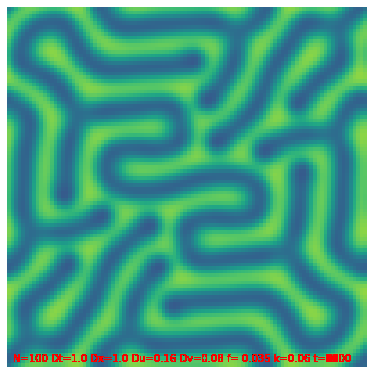

In [577]:
#default: Dt=1,Dx=1,Du=0.16,Dv=0.08,f=0.035,k=0.06 F = 0.06, k = 0.0609
N = 100      # anything
Dt = 1.0     # [0,1.66]
Dx = 1.0     # [0.99, 2.11]
Du = 0.16    # [0.16, 0.24]  
Dv = 0.08    # [0, 0.08]
f = 0.035    # [0.027, 0.038]
k = 0.060    # [0, 0.060]
noise = 0.1
iterations = 10000

#timesteps to plot
saves = [0,100,1000,5000,9999]
# saves = [1000,3000,5000,7000,9999]

#set params in string for filename
params = "N%sDt%sDx%sDu%sDv%sf%sk%sn%s" %(N,Dt,Dx,Du,Dv,f,k,noise)

#list for storing states
u_states = []
v_states = []

#initialize gif object
u_gif = AnimatedGif()
# v_gif = AnimatedGif()

#initialize concentrations
u_new, v_new = initialize_planes(N,noise)

#do reaction diffusion for number of iterations
for i in range(iterations):

    u_new,v_new = reaction_diffusion(u_new,v_new,Dt,Dx,Du,Dv,f,k)

    #save current state if in requested saves
    if i in saves:
        u_states.append(u_new)
        v_states.append(v_new)
    
    #add every 100th frame to gif
    if i%100==0:
        u_gif.add(u_new, label="N=%s Dt=%s Dx=%s Du=%s Dv=%s f= %s k=%s t=%s"%(N,Dt,Dx,Du,Dv,f,k,i))
        # v_gif.add(v_new, label="N=%s Dt=%s Dx=%s Du=%s Dv=%s f= %s k=%s t=%s"%(N,Dt,Dx,Du,Dv,f,k,i))

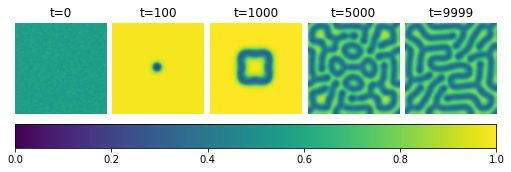

In [578]:
#create a subfigure
fig = plt.figure(constrained_layout=True,figsize=(7,3))
(subfig_l) = fig.subfigures(nrows=1, ncols=1)

axes_l = subfig_l.subplots(nrows=1, ncols=5, sharey=True)
for i,ax in enumerate(axes_l):
    im = ax.imshow(u_states[i], vmin=0, vmax=1)
    ax.set_title(f't={saves[i]}')
    ax.label_outer()
    ax.axis('off')

#add the colorbar
subfig_l.colorbar(im, ax=axes_l, location='bottom')

#save the figure
plt.savefig(f"Figures/u_diffusion{params}.svg",format="svg", dpi=300)

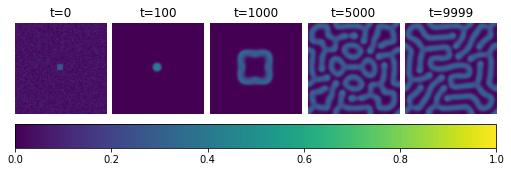

In [579]:
#create a subfigure
fig = plt.figure(constrained_layout=True,figsize=(7,3))
(subfig_l) = fig.subfigures(nrows=1, ncols=1)

#titles:
titles = ["0","10","100","1000","9999"]

axes_l = subfig_l.subplots(nrows=1, ncols=5, sharey=True)
for i,ax in enumerate(axes_l):
    im = ax.imshow(v_states[i], vmin=0, vmax=1)
    ax.set_title(f't={saves[i]}')
    ax.label_outer()
    ax.axis('off')

#add the colorbar
subfig_l.colorbar(im, ax=axes_l, location='bottom')

#save the figure
plt.savefig(f"Figures/v_diffusion{params}.svg",format="svg", dpi=300)

In [580]:
#save the gifs
u_gif.save(f'Gifs/u_diffusion{params}.gif',fps=10)
# v_gif.save(f'Gifs/v_diffusion{params}.gif',fps=10)

### Range of parameters side by side